# Previsão da série temporal de produção de energia nuclear nos Estados Unidos, utilizando 2 modelos de previsão.
#### Modelos utilizados:
- MLP (Um modelo de rede Neural)
- XGBoost (um modelo baseado em arvore)

## Importando as bibliotecas nescessárias para a atividade

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import warnings

from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
warnings.filterwarnings('ignore')

## Fazendo a carga dos dados e a divisão entre teste, treino e validação

In [3]:
path = '/content/electricity_Consumption_Productioction.csv'
dados = pd.read_csv(path)

In [4]:
dados


,Date,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01,5957.666667,5924.416667,1391.750000,343.583333,1285.875000,1418.000000,1408.708333,43.291667,32.791667
1,2019-01-02,6322.041667,6795.708333,1390.833333,1106.750000,1252.708333,1615.166667,1340.625000,53.333333,35.750000
2,2019-01-03,7254.083333,7202.250000,1372.041667,989.291667,1477.208333,1822.166667,1467.708333,33.333333,39.833333
3,2019-01-04,7635.083333,7988.500000,1371.416667,1854.583333,1411.833333,1742.000000,1519.541667,45.500000,43.250000
4,2019-01-05,7379.750000,6836.208333,1393.333333,629.500000,1212.041667,1839.916667,1626.291667,92.750000,42.000000
...,...,...,...,...,...,...,...,...,...,...
1912,2024-03-27,6454.625000,7685.625000,1374.750000,1920.208333,1967.916667,1515.250000,612.916667,222.875000,68.083333
1913,2024-03-28,6304.125000,7255.083333,1358.541667,1676.416667,1916.416667,1388.000000,613.291667,232.333333,69.000000
1914,2024-03-29,5898.208333,6162.250000,1374.791667,963.958333,1684.916667,1123.833333,589.000000,358.666667,65.875000
1915,2024-03-30,5383.083333,6125.958333,1393.541667,1023.833333,1737.916667,1079.458333,500.833333,324.250000,65.416667


In [5]:
dados['Date'] = pd.to_datetime(dados['Date'])
dados = dados.set_index('Date')
dados = pd.DataFrame(index=dados.index, data=dados['Nuclear'])

In [6]:
rcParams['figure.figsize'] = 15, 6

<Axes: xlabel='Date'>

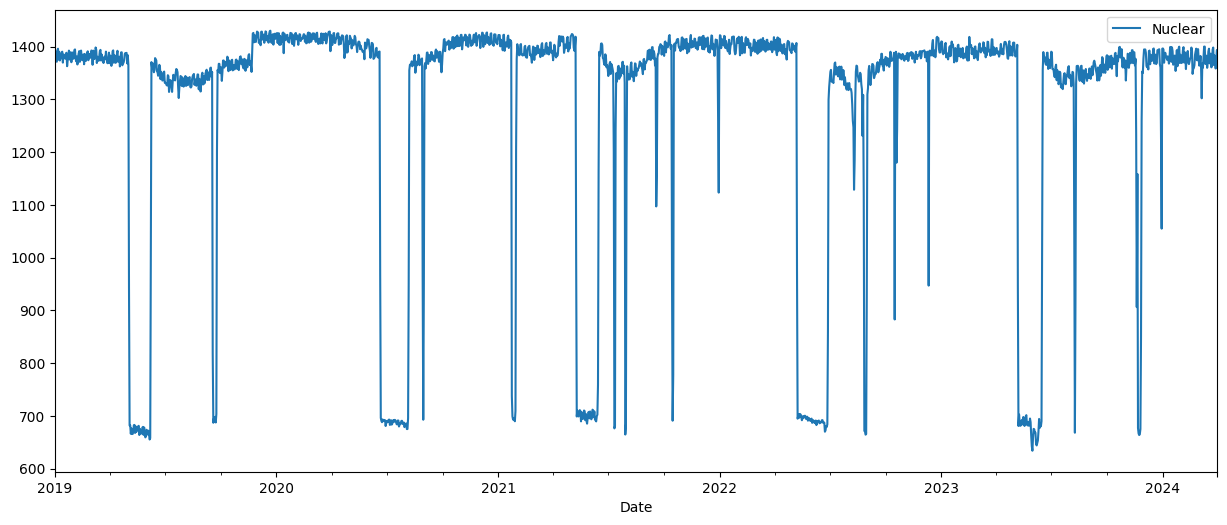

In [7]:
dados.plot()

In [8]:
train = dados.loc['2019': '2021']
val = dados.loc['2022']
test = dados.loc['2023':]

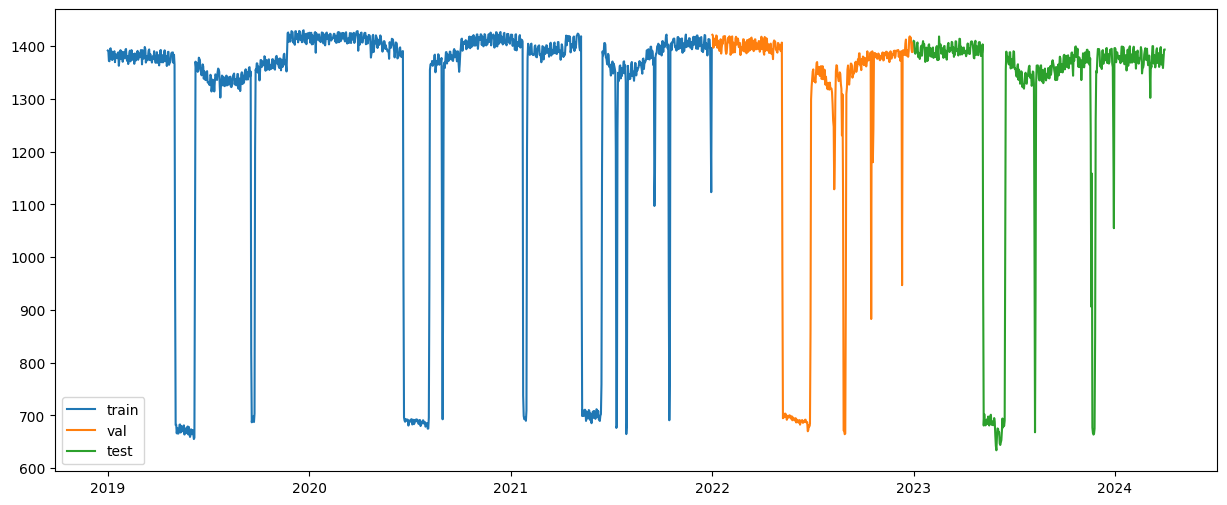

In [9]:
plt.plot(train, label = 'train')
plt.plot(val, label = 'val')
plt.plot(test, label = 'test')
plt.legend(loc = 'best')
plt.show()

### Analise dos dados

Normalização dos dados

In [10]:
scaler = MinMaxScaler()
scaler.fit(train)

X_train_scaler = scaler.transform(train)
X_val_scaler = scaler.transform(val)
X_test_scaler = scaler.transform(test)

In [11]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

In [12]:
def create_sliding_windows(series, window_size):

    list_of_sliding_windows = []
    list_size_to_iterate = len(series) - window_size
    for i in range(0, list_size_to_iterate):
        window = series[i: i + window_size + 1]
        list_of_sliding_windows.append(window)

    return np.array(list_of_sliding_windows).reshape(len(list_of_sliding_windows), window_size+1)

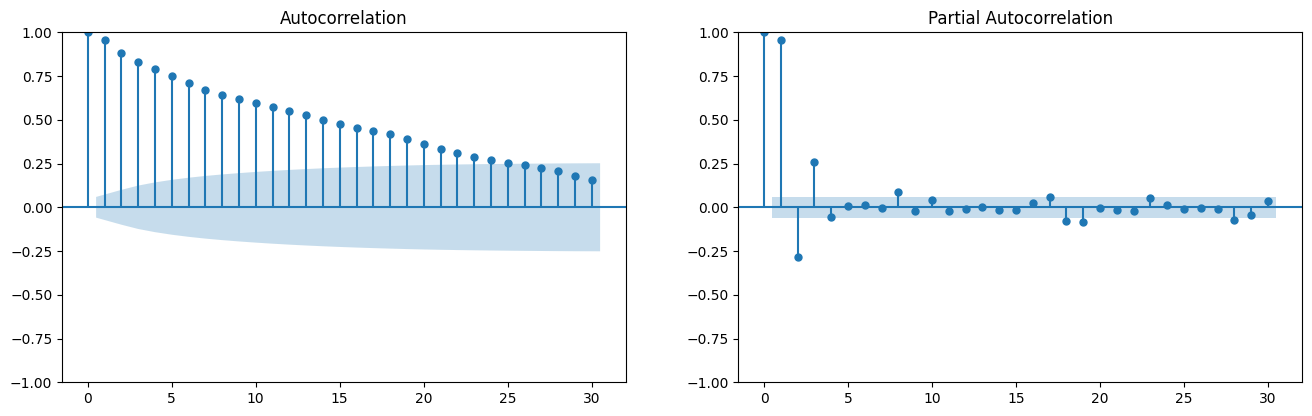

In [13]:
acf_pacf(train.values, 30)

In [14]:
train_windows = create_sliding_windows(X_train_scaler, 24)
val_windows = create_sliding_windows(X_val_scaler, 24)
test_windows = create_sliding_windows(X_test_scaler, 24)

In [15]:
X_train = train_windows[:, 0:-1]
y_train = train_windows[:, -1]

X_val = val_windows[: ,0: -1 ]
y_val = val_windows[: , -1 ]

X_test = test_windows[: ,0: -1 ]
y_test = test_windows[: , -1 ]

In [16]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

##  MLP - Multi-Layer Perceptron
- Rede neural artificial

In [17]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (50, 50, 50)],
    'activation': ['identity', 'logistic','tanh', 'relu'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

results = []
best_mse = np.inf

for hidden_layer_sizes in param_grid['hidden_layer_sizes']:
    for activation in param_grid['activation']:
        for solver in param_grid['solver']:
            for alpha in param_grid['alpha']:
                for learning_rate_init in param_grid['learning_rate_init']:
                    model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                                         activation=activation,
                                         solver=solver,
                                         alpha=alpha,
                                         learning_rate_init=learning_rate_init,
                                         random_state=42)

                    model.fit(X_train, y_train)

                    prev_train = model.predict(X_train)
                    prev_val = model.predict(X_val)

                    train_error = mean_absolute_percentage_error(y_train, prev_train)
                    val_error = mean_absolute_percentage_error(y_val, prev_val)

                    if (best_mse > val_error):

                      results.append({
                          'hidden_layer_sizes': hidden_layer_sizes,
                          'activation': activation,
                          'solver': solver,
                          'alpha': alpha,
                          'learning_rate_init': learning_rate_init,
                          'train_error': train_error,
                          'val_error': val_error
                      })
                      best_mse = val_error

In [18]:
best_params = min(results, key=lambda x: x['val_error'])

print("Melhores parâmetros encontrados:", best_params)

Melhores parâmetros encontrados: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate_init': 0.01, 'train_error': 96616095737.24835, 'val_error': 0.23919333502984763}


In [19]:
melhor_modelo_mlp = MLPRegressor(hidden_layer_sizes=(50, 50),
                        activation='logistic',
                        solver='lbfgs',
                        alpha=best_params['alpha'],
                        learning_rate_init=best_params['learning_rate_init'],
                        learning_rate = 'adaptive',
                        random_state=42)


melhor_modelo_mlp.fit(X_train_full, y_train_full)

MLPRegressor(activation='logistic', hidden_layer_sizes=(50, 50),
             learning_rate='adaptive', learning_rate_init=0.01, random_state=42,
             solver='lbfgs')

In [20]:
prev_train = melhor_modelo_mlp.predict(X_train_full)

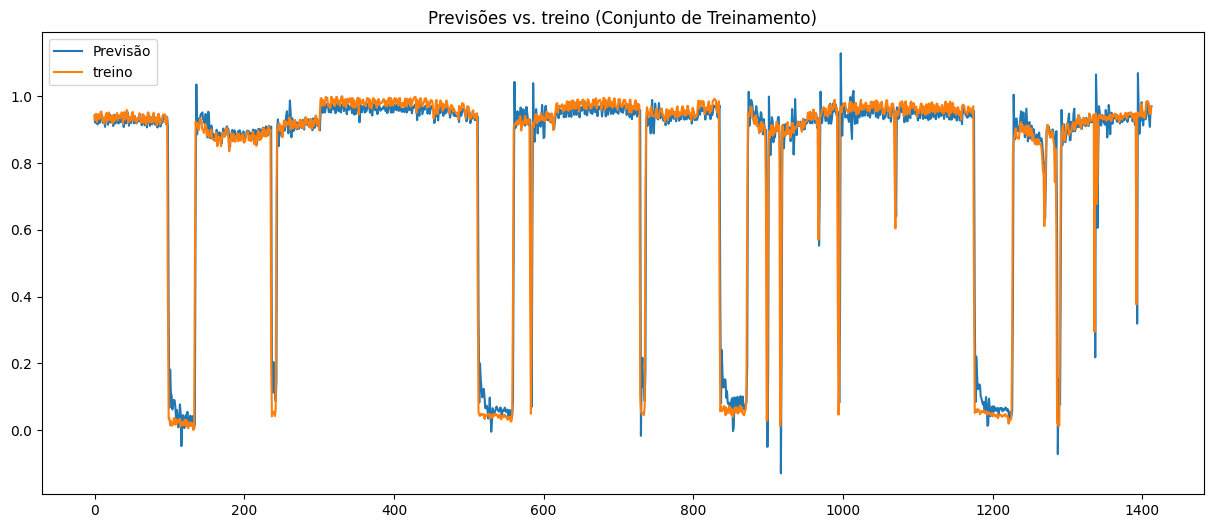

In [21]:
plt.plot(prev_train, label='Previsão')
plt.plot(y_train_full, label='treino')
plt.legend(loc='best')
plt.title('Previsões vs. treino (Conjunto de Treinamento)')
plt.show()

In [22]:
rmse_mlp = np.sqrt(mean_squared_error(y_train_full, prev_train))
mse_mlp = mean_squared_error(y_train_full, prev_train)
mape = mean_absolute_percentage_error(prev_train, y_train_full)

print(rmse_mlp)
print(mse_mlp)
print(mape)

0.08918264812344998
0.007953544726311094
0.161255358604216


In [23]:
pred_test = melhor_modelo_mlp.predict(X_test)

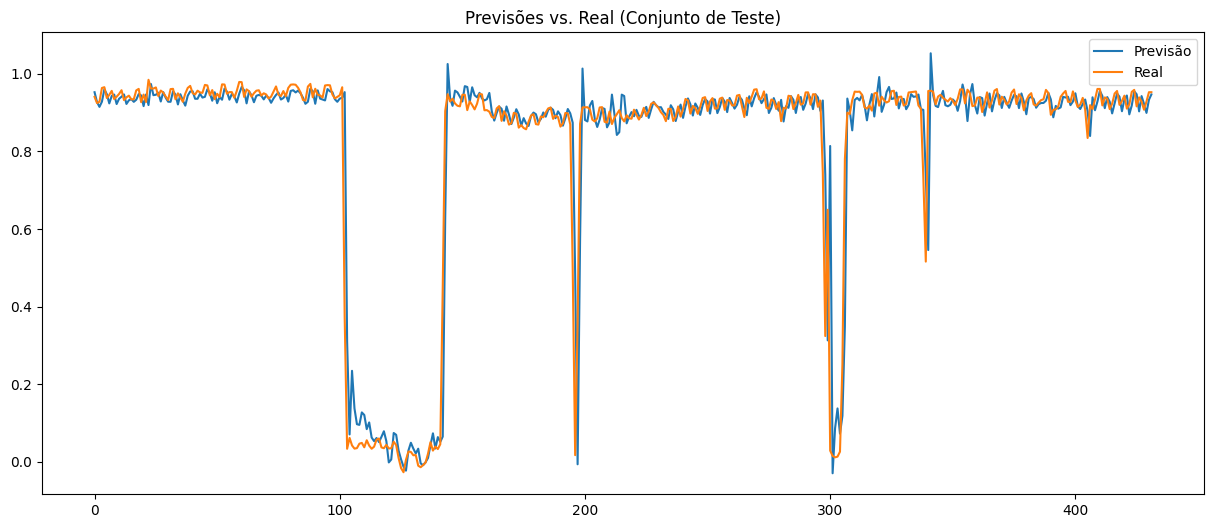

In [24]:
plt.plot(pred_test, label='Previsão')
plt.plot(y_test, label='Real')
plt.legend(loc='best')
plt.title('Previsões vs. Real (Conjunto de Teste)')
plt.show()

In [25]:
rmse_test_mlp = np.sqrt(mean_squared_error(y_test, pred_test))
mse_test_mlp = mean_squared_error(y_test, pred_test)
mape_test_mlp = mean_absolute_percentage_error(y_test, pred_test)


print(rmse_test_mlp)
print(mse_test_mlp)
print(mape_test_mlp)

0.08277010860210894
0.006850890878004909
0.33972494427451744


--- ---

## xgboost

In [26]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [27]:
n_estimators_values = [100, 200, 300]
max_depth_values = [3, 5, 7]
learning_rate_values = [0.01, 0.05, 0.1]

best_score = float('-inf')
best_params = {}

for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for learning_rate in learning_rate_values:
            model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

            scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
            mean_score = scores.mean()

            if mean_score > best_score:
                best_score = mean_score
                best_params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate}

print("Melhores parâmetros:", best_params)

Melhores parâmetros: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}


In [28]:
best_model = XGBRegressor(n_estimators=best_params['n_estimators'],
                          max_depth=best_params['max_depth'],
                          learning_rate=best_params['learning_rate'])

best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [29]:
best_model.fit(X_train_full, y_train_full)

prev_train = best_model.predict(X_train_full)

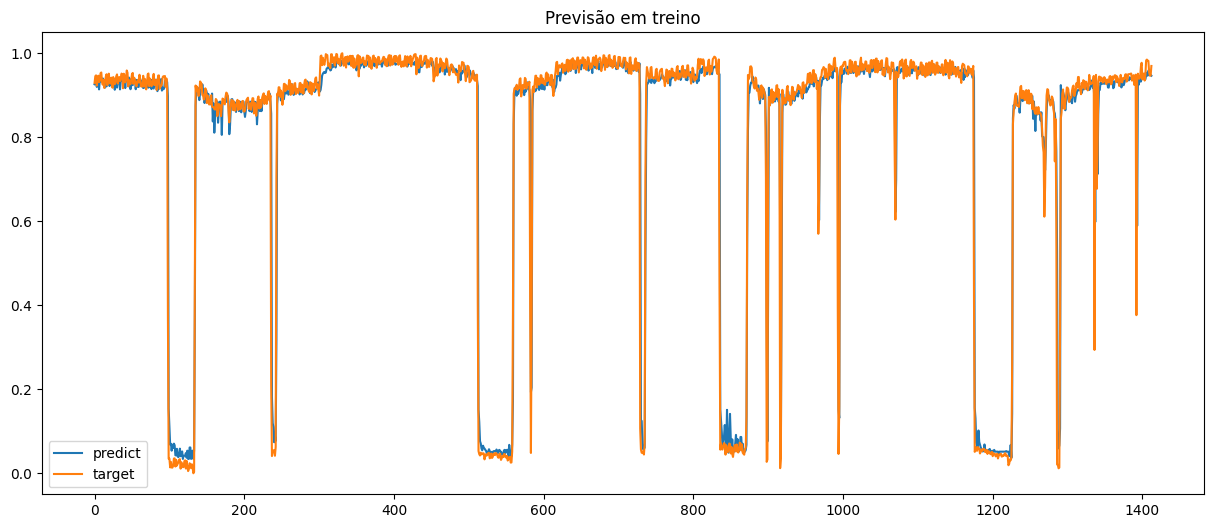

,Métricas,Resultado
0,MAPE,0.070244
1,MSE,0.004034
2,RMSE,0.063514


In [30]:
plt.title("Previsão em treino")
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

resultados = {
    "Métricas": ["MAPE", "MSE", "RMSE"],
    "Resultado": [mean_absolute_percentage_error(prev_train, y_train_full),
                              mean_squared_error(prev_train, y_train_full),
                              np.sqrt(mean_squared_error(prev_train, y_train_full))]
}

df_resultados_XGB_test = pd.DataFrame(resultados)

df_resultados_XGB_test

In [31]:
prev_test = best_model.predict(X_test)

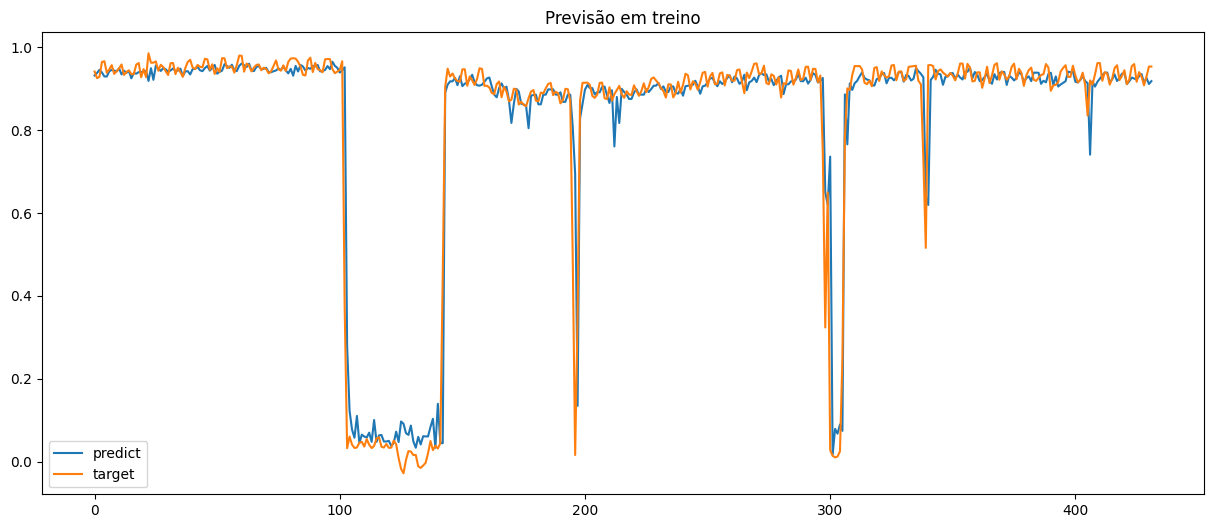

,Métricas,Resultado
0,MAPE,0.112321
1,MSE,0.005435
2,RMSE,0.073724


In [32]:
plt.title("Previsão em treino")
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

resultados = {
    "Métricas": ["MAPE", "MSE", "RMSE"],
    "Resultado": [mean_absolute_percentage_error(prev_test, y_test),
                              mean_squared_error(prev_test, y_test),
                              np.sqrt(mean_squared_error(prev_test, y_test))]
}

df_resultados_XGB_test = pd.DataFrame(resultados)

df_resultados_XGB_test

## Comparandos os modelos de teste

In [33]:
df_resultados_XGB_test

,Métricas,Resultado
0,MAPE,0.112321
1,MSE,0.005435
2,RMSE,0.073724


In [34]:
metricas = {
    'Métrica': ['MAPE' ,'mse','RMSE'],
    'Valor': [mape_test_mlp, mse_test_mlp, rmse_test_mlp]
}

pd.DataFrame(metricas)

,Métrica,Valor
0,MAPE,0.339725
1,mse,0.006851
2,RMSE,0.082770
